# 画像分析
テーブルデータの場合は列に変数として行にデータが入るようになっている。それに対して画像データも同様に行列ではあるが、テーブルデータのように見てしまうと一つの画像がデータではなくデータセットになってしまう。

そこで、画像データに対して特徴量を考える材料として、画像の特性である色の値を使用した特徴量の取得方法として画素値のヒストグラムを使用する。ここで、画像は基本的に赤・緑・青で構成されており、値は0から255までになる。

また、画像はそのままだと人が見ても色や形が分かりずらい事があるため色と形を鮮明にする手法を白黒画像で行う。
## 画像の特徴量として画素値のヒストグラム

### ライブラリのインポート

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

### 画像の読み込み

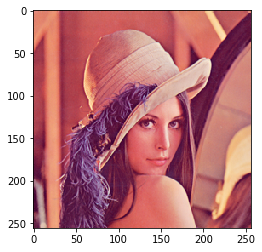

In [2]:
image = Image.open("Lenna.png")
imary = np.array(image)
plt.imshow(imary)
plt.show()

### 画素値のヒストグラムの作成

In [3]:
R_hist = np.zeros(256)
G_hist = np.zeros(256)
B_hist = np.zeros(256)

In [4]:
for y in range(len(imary)):
    for x in range(len(imary[y])):
        R_hist[imary[y][x][0]] = R_hist[imary[y][x][0]] + 1
        G_hist[imary[y][x][1]] = G_hist[imary[y][x][1]] + 1
        B_hist[imary[y][x][2]] = B_hist[imary[y][x][2]] + 1

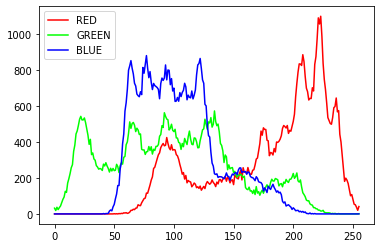

In [5]:
plt.plot(R_hist, color="#FF0000", label="RED")
plt.plot(G_hist, color="#00FF00", label="GREEN")
plt.plot(B_hist, color="#0000FF", label="BLUE")
plt.legend()
plt.show()

ここで、ヒストグラムが完成したが、この場合、縦軸のヒストグラムの値は画像の大きさに依存するところがある。そこで、大きさに依存しない形としてヒストグラムの値に対して最大最小正規化を行う。

### 最大最小正規化

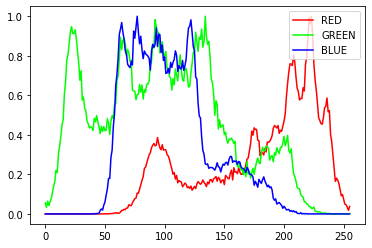

In [6]:
R_hist = ((R_hist - min(R_hist)) / (max(R_hist) - min(R_hist)))
G_hist = ((G_hist - min(G_hist)) / (max(G_hist) - min(G_hist)))
B_hist = ((B_hist - min(B_hist)) / (max(B_hist) - min(B_hist)))
plt.plot(R_hist, color="#FF0000", label="RED")
plt.plot(G_hist, color="#00FF00", label="GREEN")
plt.plot(B_hist, color="#0000FF", label="BLUE")
plt.legend()
plt.show()

## 画像の鮮明化
そもそも、基本的に前節で行った画像の画素値をヒストグラムにして特徴量にするやり方では画像の識別などは難しいため、実際には画像をモデルに学習させる場合が多い。しかし、元々の画像では形や色が分かりにくく、画像が特徴量として不向きな場合がある。そこで、色や形を鮮明にすることで特徴量をより分かりやすくする。

### 画像の読み込み
ここでは分かりやすくするため画像は白黒画像で行う。

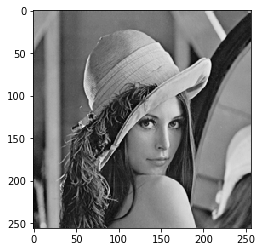

In [7]:
image = Image.open("Lenna.png").convert("L")
imary = np.array(image)
plt.imshow(imary, cmap="gray")
plt.show()

### 色を鮮明にする 
画像が分かりにくい理由の一つとして色の識別が困難な場合がある。その理由としては画像の色が特定の画素値に集中していることが理由の一つに挙げられる。そこで実際にヒストグラムを確認して画素値の集中を確認する。

手法としてはコントラスト強調を使用する。

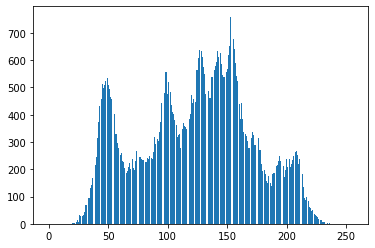

In [8]:
hist = np.zeros(256)
for y in range(len(imary)):
    for x in range(len(imary[y])):
        hist[imary[y][x]] = hist[imary[y][x]] + 1
plt.bar(np.arange(0, 256, 1), hist)
plt.show()

結果から画素値は特定の値をピークにして集中していることが分かる。ここで、画素値のヒストグラムの値を全体的に広げるため、ここで出力されたヒストグラムに対して累積ヒストグラムを用いる。

累積ヒストグラムの値を正規化して最大値を255とし、画像の画素値の値を該当する累積ヒストグラムの値で代入して画素値を変換する。

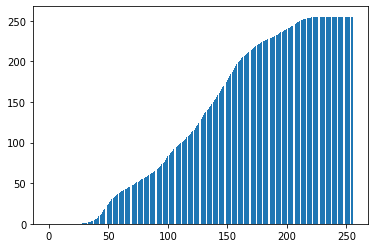

In [9]:
histsum = np.zeros(256)
for i in range(len(hist)):
    if i==0:
        histsum[i] = hist[i]
    else:
        histsum[i] = histsum[i-1] + hist[i]
histsum = ((histsum - min(histsum)) / (max(histsum) - min(histsum))) * 255
plt.bar(np.arange(0, 256, 1), histsum)
plt.show()

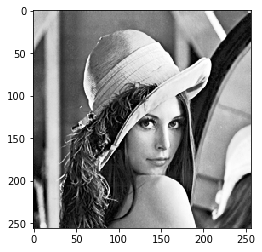

In [10]:
dst = np.zeros((len(imary), len(imary[0])))
for y in range(len(imary)):
    for x in range(len(imary[y])):
        dst[y][x] = int(histsum[imary[y][x]])
dst = dst.astype(int)
plt.imshow(dst, cmap="gray")
plt.show()

これによって色が分かりやすくなった。そこで、鮮明にした画像に対してヒストグラムを再度確認する。

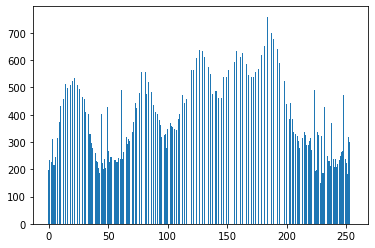

In [11]:
hist = np.zeros(256)
for y in range(len(dst)):
    for x in range(len(dst[y])):
        hist[dst[y][x]] = hist[dst[y][x]] + 1
plt.bar(np.arange(0, 256, 1), hist)
plt.show()

### 形の鮮明にする
画像が分かりにくい理由として色以外だと形が曖昧な場合がある。そこで、画像の座標に対して前後左右斜めの差を取り画像から輪郭を抽出したマスクを作成する。このマスクの値を基の画像に加算することで画素値が変化した時に変化を強調することができる。

#### マスクの作成

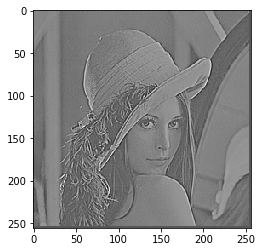

In [12]:
mask = np.zeros((len(imary), len(imary[0])))
src = imary.copy()
for y in range(len(imary)-2):
    for x in range(len(imary[y])-2):
        mask[y][x] = 10 * src[y][x] - src[y-1][x] - src[y+1][x] - src[y][x-1] - src[y][x+1] - src[y-1][x-1] - src[y-1][x+1] - src[y+1][x-1] - src[y+1][x+1]
mask = mask / 9
plt.imshow(mask, cmap="gray")
plt.show()

#### マスクを加算

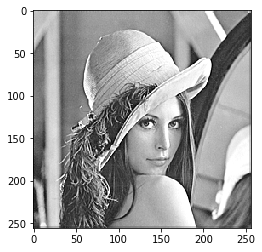

In [13]:
dst = np.zeros((len(imary), len(imary[0])))
dst = src + mask
for y in range(len(imary)-2):
    for x in range(len(imary[y])-2):
        if dst[y][x] > 255:
            dst[y][x] = 255
        if dst[y][x] < 0:
            dst[y][x] = 0
dst = dst.astype(int)
plt.imshow(dst, cmap="gray")
plt.show()

## 検出
画像から特徴量を得るときに必要な部分を取り出すことで正確に画像の特徴量を得ることができる。OpenCVを使うことで非常に簡単に検出を行うことができるが、欠点として顔を検出できない可能性や顔でないものも顔として検出する可能性も考慮しないといけない。

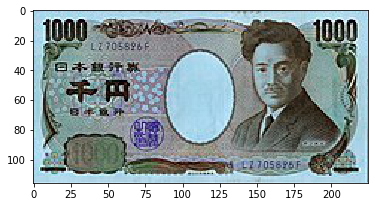

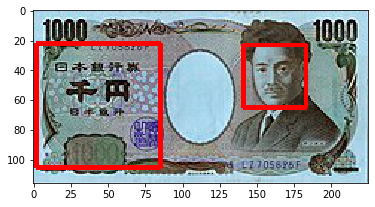

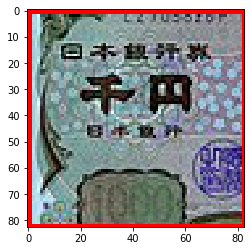

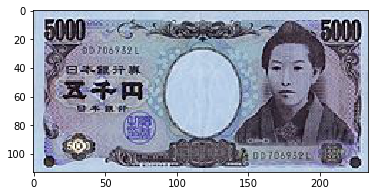

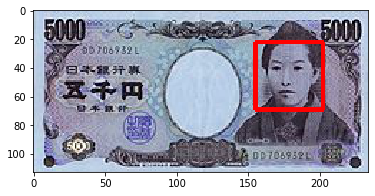

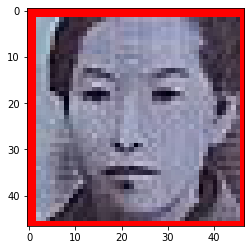

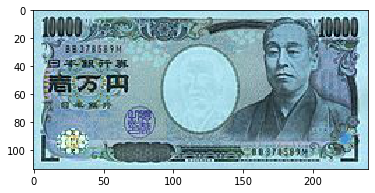

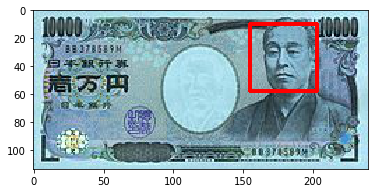

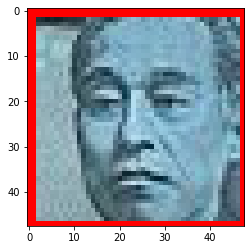

In [14]:
path = "haarcascade_frontalface_default.xml"
file = ["1000yen.jpg", "5000yen.jpg", "10000yen.jpg"]
for name in file:
    src = cv2.imread(name)
    plt.imshow(src)
    plt.show()
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(path)
    faces = face_cascade.detectMultiScale(gray)
    for x, y, w, h in faces:
        cv2.rectangle(src, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face = src[y:y+h, x:x+w]
        face_gray = gray[y:y+h, x:x+w]
    plt.imshow(src)
    plt.show()
    plt.imshow(face)
    plt.show()